*Data source:*

- [*FAOSTAT: Food and Agriculture Organization of the United Nations*](https://www.fao.org/faostat/en/#release_calendar)
- [*The world bank*](https://databank.worldbank.org/)
- *https://www.worldeconomics.com/*

**Table of contents**<a id='toc0_'></a>    
1. [Import libraries and other useful code.](#toc1_)    
2. [Read, clean and arrange datasets.](#toc2_)    
2.1. [Crop dataset](#toc2_1_)    
2.2. [Precipitations dataset](#toc2_2_)    
2.2.1. [Preprocessing](#toc2_2_1_) 
2.2.1.1. [NaN values](#toc2_2_1_1_)
2.3. [Pesticides dataset](#toc2_3_)  
2.3.1. [Preprocessing](#toc2_3_1_) 
2.3.1.1. [Outliers](#toc2_3_1_1_)   
2.4. [Fertilizers dataset](#toc2_4_)    
2.4.1. [Preprocessing](#toc2_4_1_)
2.4.1.1. [NaN values](#toc2_4_1_1_) 
2.4.1.2. [Outliers](#toc2_4_1_2_) 
2.5. [Temperature dataset](#toc2_5_)    
3. [Create final dataframe.](#toc3_)    
3.1. [Preprocessing](#toc3_1_) 
3.1.1. [NaN values](#toc3_1_1_) 
3.1.2. [Outliers](#toc3_1_2_) 

---
## 1. <a id='toc1_'></a>[Import libraries and other useful code](#toc0_)

In [126]:
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [127]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [128]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

In [129]:
sns.set(style="whitegrid")  # Seaborn Grid Style

In [5]:
# Set the display of numbers in decimal notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. <a id='toc2_'></a>[Read, clean and arrange datasets](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Crop dataset](#toc0_)

In [130]:
crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1', low_memory=False) # low_memory = False to avoid Dtypewarning

In [131]:
# correction of country names
crop['Area'].replace('Bolivia (Plurinational State of)','Bolivia', inplace=True)
crop['Area'].replace('Iran (Islamic Republic of)','Iran', inplace=True)
crop['Area'].replace('Micronesia (Federated States of)','Micronesia', inplace=True)
crop['Area'].replace('Netherlands (Kingdom of the)','Netherlands', inplace=True)
crop['Area'].replace('United Kingdom of Great Britain and Northern Ireland','United Kingdom', inplace=True)
crop['Area'].replace('Venezuela (Bolivarian Republic of)','Venezuela', inplace=True)
crop['Area'].replace('Democratic Republic of the Congo','Congo', inplace=True)
crop['Area'].replace('United States of America','United States', inplace=True)
crop['Area'].replace("Côte d'Ivoire","Cote d'Ivoire", inplace=True)
crop['Area'].replace('Russian Federation','Russia', inplace=True)
crop['Area'].replace("Democratic People's Republic of Korea",'Korea', inplace=True)
crop['Area'].replace('United Republic of Tanzania','Tanzania', inplace=True)

values_to_drop = ['China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of', 'China, mainland','European Union (27)','Ethiopia PDR','Land Locked Developing Countries','Least Developed Countries','Low Income Food Deficit Countries','Sudan (former)','World',"Lao People's Democratic Republic"]
crop = crop[~crop['Area'].isin(values_to_drop)]

In [132]:
crop.shape

(3829302, 14)

In [133]:
# To have the same years in the datasets, filter the datasets from year 1990
crop = crop[crop['Year']>=1990]

In [134]:
crop.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
29,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1990,1990,ha,6037.00,E,NaN
30,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1991,1991,ha,5500.00,A,NaN
31,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1992,1992,ha,5500.00,A,NaN
32,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1993,1993,ha,5500.00,A,NaN
33,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1994,1994,ha,5500.00,A,NaN


In [135]:
# Delete innecessary columns
crop.drop(columns=['Area Code', 'Area Code (M49)','Item Code (CPC)','Element Code','Unit','Year Code','Flag','Note'], inplace=True)

In [136]:
crop['Element'].unique()

array(['Area harvested', 'Yield', 'Production', 'Stocks',
       'Producing Animals/Slaughtered', 'Laying', 'Yield/Carcass Weight',
       'Milk Animals', 'Prod Popultn'], dtype=object)

In [137]:
# delete element types
delete_elements = ['Stocks', 'Laying', 'Milk Animals', 'Prod Popultn', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight']

# Filter the DataFrame to exclude the rows with the specified elements, and keep area harvested, yield and production
crop = crop[~crop['Element'].isin(delete_elements)]

In [138]:
# Change the name to Elements type
crop['Element'] = crop['Element'].replace('Area harvested', 'area_harvested_ha')
crop['Element'] = crop['Element'].replace('Yield', 'yield_hg/ha')
crop['Element'] = crop['Element'].replace('Production', 'production_tonnes')

In [139]:
# Item column contains primary crops, processed crops, primary livestock, processed livestock and live animals. We are keeping only the primary crops:
primarycrops_list = [
    'Abaca, manila hemp, raw',
    'Agave fibres, raw, n.e.c.',
    'Almonds, in shell',
    'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw',
    'Apples',
    'Apricots',
    'Areca nuts',
    'Artichokes',
    'Asparagus',
    'Avocados',
    'Balata, gutta-percha, guayule, chicle and similar natural gums in primary forms or in plates, sheets or strip',
    'Bambara beans, dry',
    'Bananas',
    'Barley',
    'Beans, dry',
    'Blueberries',
    'Brazil nuts, in shell',
    'Broad beans and horse beans, dry',
    'Broad beans and horse beans, green',
    'Buckwheat',
    'Cabbages',
    'Canary seed',
    'Cantaloupes and other melons',
    'Carrots and turnips',
    'Cashew nuts, in shell',
    'Cashewapple',
    'Cassava leaves',
    'Cassava, fresh',
    'Castor oil seeds',
    'Cauliflowers and broccoli',
    'Cereals n.e.c.',
    'Cherries',
    'Chestnuts, in shell',
    'Chick peas, dry',
    'Chicory roots',
    'Chillies and peppers, dry (Capsicum spp., Pimenta spp.), raw',
    'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)',
    'Cinnamon and cinnamon-tree flowers, raw',
    'Cloves (whole stems), raw',
    'Cocoa beans',
    'Coconuts, in shell',
    'Coffee, green',
    'Coir, raw',
    'Cow peas, dry',
    'Cranberries',
    'Crops, primary > (List)',
    'Cucumbers and gherkins',
    'Currants',
    'Dates',
    'Edible roots and tubers with high starch or inulin content, n.e.c., fresh',
    'Eggplants (aubergines)',
    'Figs',
    'Flax, raw or retted',
    'Fonio',
    'Ginger, raw',
    'Gooseberries',
    'Grapes',
    'Green corn (maize)',
    'Green garlic',
    'Groundnuts, excluding shelled',
    'Hazelnuts, in shell',
    'Hempseed',
    'Hop cones',
    'Jojoba seeds',
    'Jute, raw or retted',
    'Kapok fruit',
    'Karite nuts (sheanuts)',
    'Kenaf, and other textile bast fibres, raw or retted',
    'Kiwi fruit',
    'Kola nuts',
    'Leeks and other alliaceous vegetables',
    'Lemons and limes',
    'Lentils, dry',
    'Lettuce and chicory',
    'Linseed',
    'Locust beans (carobs)',
    'Lupins',
    'Maize (corn)',
    'Mangoes, guavas and mangosteens',
    'Maté leaves',
    'Melonseed',
    'Millet',
    'Mixed grain',
    'Mushrooms and truffles',
    'Mustard seed',
    'Natural rubber in primary forms',
    'Nutmeg, mace, cardamoms, raw',
    'Oats',
    'Oil palm fruit',
    'Okra',
    'Olives',
    'Onions and shallots, dry (excluding dehydrated)',
    'Onions and shallots, green',
    'Oranges',
    'Other beans, green',
    'Other berries and fruits of the genus vaccinium n.e.c.',
    'Other citrus fruit, n.e.c.',
    'Other fibre crops, raw, n.e.c.',
    'Other fruits, n.e.c.',
    'Other nuts (excluding wild edible nuts and groundnuts), in shell, n.e.c.',
    'Other oil seeds, n.e.c.',
    'Other pome fruits',
    'Other pulses n.e.c.',
    'Other stimulant, spice and aromatic crops, n.e.c.',
    'Other stone fruits',
    'Other sugar crops n.e.c.',
    'Other tropical fruits, n.e.c.',
    'Other vegetables, fresh n.e.c.',
    'Papayas',
    'Peaches and nectarines',
    'Pears',
    'Peas, dry',
    'Peas, green',
    'Pepper (Piper spp.), raw',
    'Peppermint, spearmint',
    'Persimmons',
    'Pigeon peas, dry',
    'Pineapples',
    'Pistachios, in shell',
    'Plantains and cooking bananas',
    'Plums and sloes',
    'Pomelos and grapefruits',
    'Poppy seed',
    'Potatoes',
    'Pumpkins, squash and gourds',
    'Pyrethrum, dried flowers',
    'Quinces',
    'Quinoa',
    'Ramie, raw or retted',
    'Rape or colza seed',
    'Raspberries',
    'Rice',
    'Rye',
    'Safflower seed',
    'Seed cotton, unginned',
    'Sesame seed',
    'Sisal, raw',
    'Sorghum',
    'Sour cherries',
    'Soya beans',
    'Spinach',
    'Strawberries',
    'String beans',
    'Sugar beet',
    'Sugar cane',
    'Sunflower seed',
    'Sweet potatoes',
    'Tallowtree seeds',
    'Tangerines, mandarins, clementines',
    'Taro',
    'Tea leaves',
    'Tomatoes',
    'Triticale',
    'True hemp, raw or retted',
    'Tung nuts',
    'Unmanufactured tobacco',
    'Vanilla, raw',
    'Vetches',
    'Walnuts, in shell',
    'Watermelons',
    'Wheat',
    'Yams',
    'Yautia'
]

In [140]:
# Filter the DataFrame to keep only the rows with the specified elements
crop = crop[crop['Item'].isin(primarycrops_list)]

In [141]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, Item and Year.

crop = crop.pivot_table(index=['Area', 'Item Code', 'Item', 'Year'], columns='Element', values='Value').reset_index()
# index: The columns we want to keep unchanged in the resulting DataFrame.
# columns: The column whose values will be used to create the new columns in the resulting DataFrame.
# values: The column whose values will be used to populate the resulting DataFrame. 

In [142]:
# Change the name to the Item column
crop.rename(columns={'Item': 'Crop'}, inplace=True)

In [393]:
crop.head()

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.0,1650000.0,10510.0
1,Afghanistan,15,Wheat,1991,1690000.0,1726000.0,10213.0
2,Afghanistan,15,Wheat,1992,1600000.0,1650000.0,10313.0
3,Afghanistan,15,Wheat,1993,1900000.0,1940000.0,10211.0
4,Afghanistan,15,Wheat,1994,2000000.0,2050000.0,10250.0


### 2.2. <a id='toc2_2_'></a>[Precipitations dataset](#toc0_)

In [143]:
prec = pd.read_csv('Data/TWB_avg_precip/0b1dbe54-6204-43c1-8bd8-dbbc6763a4dd_Series - Metadata.csv',encoding='latin-1') # Average precipitation in depth (mm per year)

In [144]:
# Delete innecessary columns
prec.drop(columns=['Series Name', 'Series Code','Country Code'], inplace=True)

In [145]:
# Change name columns
col = prec.columns
# Apply the regular expression using comprehension lists
years = [re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else 'Area' for x in col]
# Change name columns with the new list years
prec.columns = years

In [146]:
prec.head()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,..,..,..
1,Albania,1485,1485,1485,1485,1485,1485,1485,1485,1485,...,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Algeria,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,..,..,..
3,American Samoa,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [147]:
prec['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands',

In [148]:
# correction of country names
prec['Area'].replace('Venezuela, RB','Venezuela', inplace=True)
prec['Area'].replace('Iran, Islamic Rep.','Iran', inplace=True)
prec['Area'].replace('Congo, Dem. Rep','Congo', inplace=True)
prec['Area'].replace('Russian Federation','Russia', inplace=True)

In [149]:
prec.tail()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,Indicator Name,Source,Topic,Periodicity,Development relevance,Limitations and exceptions,License URL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Average precipitation in depth (mm per year),"Food and Agriculture Organization, electronic ...",Environment: Land use,Annual,The agriculture sector is the most water-inten...,The data are collected by the Food and Agricul...,https://datacatalog.worldbank.org/public-licen...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
# delete the last two rows
prec = prec.iloc[:-2]

There are a lot of nan in the back rows, this will be addressed in the preprocessing section.

In [151]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    266 non-null    object
 2   1991    266 non-null    object
 3   1999    266 non-null    object
 4   2000    266 non-null    object
 5   2001    266 non-null    object
 6   2002    266 non-null    object
 7   2003    266 non-null    object
 8   2004    266 non-null    object
 9   2005    266 non-null    object
 10  2006    266 non-null    object
 11  2007    266 non-null    object
 12  2014    266 non-null    object
 13  2015    266 non-null    object
 14  2016    266 non-null    object
 15  2017    266 non-null    object
 16  2018    266 non-null    object
 17  2019    266 non-null    object
 18  2020    266 non-null    object
 19  2021    266 non-null    object
 20  2022    266 non-null    object
 21  2023    266 non-null    object
dtypes: object(22)
memory usage

#### 2.2.1. <a id='toc2_2_1_'></a>[Preprocessing](#toc0_)

##### 2.2.1.1. <a id='toc2_2_1_1_'></a>[NaN values](#toc2_2_1_1_)

In [152]:
# replace .. by NaN
prec.replace('..', np.nan, inplace=True)

<Axes: >

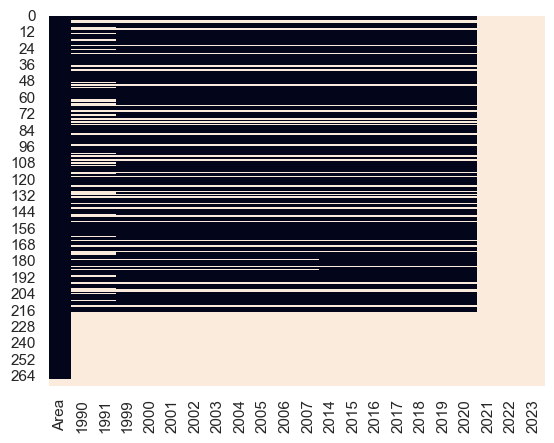

In [153]:
sns.heatmap(prec.isnull(), cbar=False) # Visualize null values with a heatmap

In [154]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area     1.85
1990    42.07
1991    42.07
1999    33.58
2000    33.58
2001    33.58
2002    33.58
2003    33.58
2004    33.58
2005    33.58
2006    33.58
2007    33.58
2014    32.84
2015    32.84
2016    32.84
2017    32.84
2018    32.84
2019    32.84
2020    32.84
2021   100.00
2022   100.00
2023   100.00
dtype: float64

In [155]:
# percentage of nan values (rows)
prec.isnull().sum(axis=1) / prec.shape[1] * 100

0      13.64
1      13.64
2      13.64
3      95.45
4      95.45
       ...  
266   100.00
267   100.00
268   100.00
269   100.00
270   100.00
Length: 271, dtype: float64

In [156]:
# # Calculate the percentage of null values in each row
percent_missing_rows = prec.isnull().sum(axis=1) / prec.shape[1] * 100

# Filter out rows with a percentage of nulls = 100
missing_rows = percent_missing_rows[percent_missing_rows==100].index

# Display rows with a percentage of nulls = 100
prec.loc[missing_rows]

# delete missing_rows
prec.drop(missing_rows, inplace=True)

In [157]:
# no information of the columns 2021, 2022, 2023. Delete

prec.drop(columns=['2021', '2022','2023'], inplace=True)

In [158]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area    0.00
1990   40.98
1991   40.98
1999   32.33
2000   32.33
2001   32.33
2002   32.33
2003   32.33
2004   32.33
2005   32.33
2006   32.33
2007   32.33
2014   31.58
2015   31.58
2016   31.58
2017   31.58
2018   31.58
2019   31.58
2020   31.58
dtype: float64

In [159]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    157 non-null    object
 2   1991    157 non-null    object
 3   1999    180 non-null    object
 4   2000    180 non-null    object
 5   2001    180 non-null    object
 6   2002    180 non-null    object
 7   2003    180 non-null    object
 8   2004    180 non-null    object
 9   2005    180 non-null    object
 10  2006    180 non-null    object
 11  2007    180 non-null    object
 12  2014    182 non-null    object
 13  2015    182 non-null    object
 14  2016    182 non-null    object
 15  2017    182 non-null    object
 16  2018    182 non-null    object
 17  2019    182 non-null    object
 18  2020    182 non-null    object
dtypes: object(19)
memory usage: 39.6+ KB


In [160]:
prec.columns

Index(['Area', '1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

In [161]:
# Change the number columns type to float
year_col = ['1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020']
prec[year_col]= prec[year_col].astype(float)

As the rainfall values are mm per year and they are continuous variables, we will do the imputation with the mean value of mm per year:

In [162]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in prec.columns:
    repair_null(prec, col)

prec.isnull().sum()/len(prec)*100

Area   0.00
1990   0.00
1991   0.00
1999   0.00
2000   0.00
2001   0.00
2002   0.00
2003   0.00
2004   0.00
2005   0.00
2006   0.00
2007   0.00
2014   0.00
2015   0.00
2016   0.00
2017   0.00
2018   0.00
2019   0.00
2020   0.00
dtype: float64

In [163]:
# calculation of the average rain fall from 1990-present in a new column

prec['avg_rainfall_mm_year'] = prec[year_col].mean(axis=1).round(2)

In [164]:
# create a new df with Area and average columns
prec_filtered = prec[['Area','avg_rainfall_mm_year']].copy()

In [352]:
prec_filtered

,Area,avg_rainfall_mm_year
0,Afghanistan,327.00
1,Albania,1485.00
2,Algeria,89.00
3,American Samoa,1183.25
4,Andorra,1183.25
...,...,...
261,Sub-Saharan Africa,1183.25
262,Sub-Saharan Africa (excluding high income),1183.25
263,Sub-Saharan Africa (IDA & IBRD countries),1183.25
264,Upper middle income,1183.25


### 2.3. <a id='toc2_3_'></a>[Pesticides dataset](#toc0_)

In [329]:
pest = pd.read_csv('Data/pesticides_use/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv',encoding='latin-1',low_memory=False)

In [330]:
# To have the same years in the datasets, filter the datasets from year 1990
pest = pest[pest['Year']>=1990]

In [331]:
pest.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1990,1990,t,121.00,E,NaN
1,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1991,1991,t,121.00,E,NaN
2,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1992,1992,t,121.00,E,NaN
3,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1993,1993,t,121.00,E,NaN
4,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1994,1994,t,201.00,E,NaN


In [332]:
pest['Element'].unique()

array(['Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [333]:
# delete element types
delete_elements = ['Use per capita','Use per area of cropland','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
pest = pest[~pest['Element'].isin(delete_elements)]

In [334]:
# create new filtered df
pest_filtered = pest[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
pest_filtered.rename(columns={'Item': 'pesticides_type'}, inplace=True)
pest_filtered.rename(columns={'Value': 'agricultural_use_tonnes'}, inplace=True)
# Delete Element column
pest_filtered.drop(columns=['Element'], inplace=True)

In [335]:
pest_filtered['pesticides_type'].unique()

array(['Pesticides (total)', 'Insecticides',
       'Insecticides \x96 Chlorinated Hydrocarbons',
       'Insecticides \x96 Organo-phosphates',
       'Insecticides \x96 Carbamates', 'Insecticides \x96 Pyrethroids',
       'Insecticides \x96 Other', 'Herbicides',
       'Herbicides \x96 Phenoxy hormone products',
       'Herbicides \x96 Triazines', 'Herbicides \x96 Amides',
       'Herbicides \x96 Carbamates', 'Herbicides \x96 Dinitroanilines',
       'Herbicides \x96 Sulfonyl ureas', 'Herbicides \x96 Bipiridils',
       'Herbicides \x96 Other', 'Fungicides and Bactericides',
       'Fung & Bact \x96 Inorganics', 'Fung & Bact \x96 Dithiocarbamates',
       'Fung & Bact \x96 Benzimidazoles',
       'Fung & Bact \x96 Triazoles, diazoles', 'Fung & Bact \x96 Other',
       'Fungicides \x96 Seed treatments',
       'Insecticides \x96 Seed Treatments', 'Plant Growth Regulators',
       'Rodenticides', 'Rodenticides \x96 Anti-coagulants',
       'Rodenticides \x96 Other', 'Other Pesticides ne

In [336]:
# Clean pesticides_type column
pest_filtered['pesticides_type'] = pest_filtered['pesticides_type'].str.replace('\x96', ':')

In [337]:
# Delete pesticides (total) element
# delete element types
delete_elements = ['Pesticides (total)']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
pest_filtered = pest_filtered[~pest_filtered['pesticides_type'].isin(delete_elements)]

In [348]:
pest_filtered['pesticides_type'].value_counts()

pesticides_type
Insecticides                                            7703
Fungicides and Bactericides                             7414
Herbicides                                              7328
Plant Growth Regulators                                 4886
Rodenticides                                            4704
Other Pesticides nes                                    4098
Mineral Oils                                            3518
Fungicides : Seed treatments                            2909
Insecticides : Seed Treatments                          2422
Insecticides : Organo-phosphates                        1366
Insecticides : Pyrethroids                              1352
Insecticides : Other                                    1250
Herbicides : Other                                      1245
Fung & Bact : Other                                     1209
Fung & Bact : Dithiocarbamates                          1201
Disinfectants                                           1169
Insectic

In [349]:
#Create a new column grouping pesticides_type:

# Iterate over the rows of the DataFrame 
for index, row in pest_filtered.iterrows():
    pesticide_type = row['pesticides_type']
    
    if pesticide_type.startswith('Insecticides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Insecticides' #  to assign the value to the pesticide group to each cell individually in the column 'pesticides_group' 
    elif pesticide_type.startswith('Herbicides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Herbicides'
    elif pesticide_type.startswith('Fung & Bact') or pesticide_type.startswith('Fungicides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Fungicides and Bactericides'
    elif pesticide_type.startswith('Rodenticides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Rodenticides'
    elif pesticide_type.startswith('Seed Treat'):
        pest_filtered.at[index, 'pesticides_group'] = 'Seed Treatments'
    else:
        pest_filtered.at[index, 'pesticides_group'] = pesticide_type

In [340]:
pest_filtered['pesticides_group'].unique()

array(['Insecticides', 'Herbicides', 'Fungicides and Bactericides',
       'Plant Growth Regulators', 'Rodenticides', 'Other Pesticides nes',
       'Mineral Oils', 'Disinfectants', 'Seed Treatments'], dtype=object)

#### 2.3.1. <a id='toc2_3_1_'></a>[Preprocessing](#toc0_)

In [341]:
pest_filtered.isnull().sum()

Area                       0
pesticides_type            0
Year                       0
agricultural_use_tonnes    0
pesticides_group           0
dtype: int64

#### 2.3.1.1. <a id='toc2_3_1_1_'></a>[Outliers](#toc0_)

In [350]:
pest_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69925 entries, 128 to 112332
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     69925 non-null  object 
 1   pesticides_type          69925 non-null  object 
 2   Year                     69925 non-null  int64  
 3   agricultural_use_tonnes  69925 non-null  float64
 4   pesticides_group         69925 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.2+ MB


In [351]:
pest_filtered['agricultural_use_tonnes'].describe().T.round(2)

count     69925.00
mean       5382.45
std       41586.32
min           0.01
25%           4.00
50%          55.79
75%         560.00
max     1730303.03
Name: agricultural_use_tonnes, dtype: float64

In [352]:
# There are many agricultural use at 0. Delete these rows
pest_filtered[pest_filtered['agricultural_use_tonnes']==0]

pest_filtered = pest_filtered[pest_filtered['agricultural_use_tonnes'] != 0]
pest_filtered.shape

(69925, 5)

In [345]:
# # Create boxplot
# pest_var = pest_filtered['agricultural_use_tonnes']
# ax = sns.boxplot(y=pest_var, data=pest_filtered, color = agro[3]) 
# ax.set_title('Agricultural use (tonnes)')
# ax.set_ylabel('')  

# plt.show()

In [346]:
# # repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
# def repair_outliers(df, col):
#     Q1 = col.quantile(0.25)
#     Q3 = col.quantile(0.75)
#     IQR = Q3 - Q1
    
#     outlier_lower = Q1 - (1.5 * IQR)
#     outlier_upper = Q3 + (1.5 * IQR)
    
#     for i in range(len(df[col.name])): 
#         if i in df.index:  
#             element = df.loc[i, col.name] 
#             if element > outlier_upper: 
#                 df.loc[i, col.name] = outlier_upper
#             elif element < outlier_lower: 
#                 df.loc[i, col.name] = outlier_lower
            
#     return df  

# repair_outliers(pest_filtered, pest_var)

In [347]:
# # Create boxplot

# ax = sns.boxplot(y=pest_var, data=pest_filtered, color = agro[3]) 
# ax.set_title('Agricultural use (tonnes)')
# ax.set_ylabel('')  

# plt.show()

In [353]:
# Save pest_filtered in csv:
pest_filtered.to_csv('Data/pest_preprocessed.csv', index=False)

### 2.4. <a id='toc2_4_'></a>[Fertilizers dataset](#toc0_)

In [254]:
fert = pd.read_csv('Data/fertilizers/Inputs_FertilizersNutrient_E_All_Data_Normalized.csv',encoding='latin-1',low_memory=False)

In [255]:
# To have the same years in the datasets, filter the datasets from year 1990
fert_filtered = fert[fert['Year']>=1990]

In [256]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1974,1974,t,19117.00,A,Official data from questionnaire
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1975,1975,t,14774.00,A,Official data from questionnaire
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1976,1976,t,26203.00,A,Official data from questionnaire
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1977,1977,t,37689.00,A,Official data from questionnaire
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1978,1978,t,48300.00,A,Official data from questionnaire


In [257]:
fert['Element'].unique()

array(['Production', 'Import Quantity', 'Export Quantity',
       'Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [258]:
# delete element types
delete_elements = ['Import Quantity', 'Export Quantity', 'Use per capita','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
fert = fert[~fert['Element'].isin(delete_elements)]
# Change the name to Elements type
fert['Element'] = fert['Element'].replace('Production', 'production_tonnes')
fert['Element'] = fert['Element'].replace('Agricultural Use', 'agricultural_use_tonnes')
fert['Element'] = fert['Element'].replace('Use per area of cropland', 'use_per_area_kg/ha')

In [259]:
# create new filtered df
fert_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
fert_filtered.rename(columns={'Item': 'fertilizer_type'}, inplace=True)

In [260]:
fert_filtered['Element'].value_counts()

Element
agricultural_use_tonnes    35760
use_per_area_kg/ha         35655
production_tonnes          19888
Name: count, dtype: int64

In [261]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, fertilizer_type and Year.

fert_filtered = fert_filtered.pivot_table(index=['Area', 'fertilizer_type', 'Year'], columns='Element', values='Value').reset_index()

In [262]:
fert_filtered.head(2)

Element,Area,fertilizer_type,Year,agricultural_use_tonnes,production_tonnes,use_per_area_kg/ha
0,Afghanistan,Nutrient nitrogen N (total),1961,1000.00,NaN,0.13
1,Afghanistan,Nutrient nitrogen N (total),1962,1000.00,NaN,0.13


In [263]:
fert_filtered['fertilizer_type'].value_counts()

fertilizer_type
Nutrient nitrogen N (total)        12295
Nutrient phosphate P2O5 (total)    11964
Nutrient potash K2O (total)        11657
Name: count, dtype: int64

#### 2.4.1. <a id='toc2_4_1_'></a>[Preprocessing](#toc0_)

##### 2.4.1.1. <a id='toc2_4_1_1_'></a>[NaN values](#toc0_)

In [264]:
fert_filtered.isnull().sum()

Element
Area                           0
fertilizer_type                0
Year                           0
agricultural_use_tonnes      156
production_tonnes          16028
use_per_area_kg/ha           261
dtype: int64

In [265]:
fert_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35916 entries, 0 to 35915
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     35916 non-null  object 
 1   fertilizer_type          35916 non-null  object 
 2   Year                     35916 non-null  int64  
 3   agricultural_use_tonnes  35760 non-null  float64
 4   production_tonnes        19888 non-null  float64
 5   use_per_area_kg/ha       35655 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.6+ MB


As the **agricultural use, production and use per area** are continuous variables, we will do the imputation with the mean value:

In [266]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in fert_filtered.columns:
    repair_null(fert_filtered, col)

fert_filtered.isnull().sum()/len(fert_filtered)*100

Element
Area                      0.00
fertilizer_type           0.00
Year                      0.00
agricultural_use_tonnes   0.00
production_tonnes         0.00
use_per_area_kg/ha        0.00
dtype: float64

##### 2.4.1.2. <a id='toc2_4_1_2_'></a>[Outliers](#toc0_)

In [267]:
# convert year variable to object type, because it's a discrete variable
fert_filtered['Year'] = fert_filtered['Year'].astype(object)

In [268]:
fert_filtered.shape

(35916, 6)

In [269]:
fert_filtered.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Element,,,,,,,,
agricultural_use_tonnes,35916.00,960964.59,4638662.76,0.00,1739.51,24491.50,230637.25,110541658.96
production_tonnes,35916.00,1827674.20,4892066.96,0.00,55000.00,1827674.20,1827674.20,122741092.16
use_per_area_kg/ha,35916.00,28.16,40.82,0.00,2.41,12.40,36.38,412.29


In [270]:
# the minimun value is 0 in the three variables. Delete these rows
fert_filtered = fert_filtered[~((fert_filtered['agricultural_use_tonnes'] == 0) | (fert_filtered['production_tonnes'] == 0) | (fert_filtered['use_per_area_kg/ha'] == 0))]
fert_filtered.shape

(29702, 6)

In [271]:
# visualise outliers: This function prints the outliers for each column.

def outliers (df):
    for columns in df:
        if df[columns].dtype in ['int64', 'float64']: 

            Q1 = df[columns].quantile(0.25)
            Q3 = df[columns].quantile(0.75)
            IQR = Q3 - Q1
            outlierLeft = Q1-(1.5*IQR)
            outlierRight = Q3+(1.5*IQR)
            outliers = df[columns][(df[columns] < outlierLeft) | (df[columns] > outlierRight)]
            print("Variable " + columns + " has " + str(len(outliers)) + " outliers")

    
outliers(fert_filtered)

Variable agricultural_use_tonnes has 4838 outliers
Variable production_tonnes has 2045 outliers
Variable use_per_area_kg/ha has 2279 outliers


In [272]:
fert_filtered.head()

Element,Area,fertilizer_type,Year,agricultural_use_tonnes,production_tonnes,use_per_area_kg/ha
0,Afghanistan,Nutrient nitrogen N (total),1961,1000.00,1827674.20,0.13
1,Afghanistan,Nutrient nitrogen N (total),1962,1000.00,1827674.20,0.13
2,Afghanistan,Nutrient nitrogen N (total),1963,1000.00,1827674.20,0.13
3,Afghanistan,Nutrient nitrogen N (total),1964,1000.00,1827674.20,0.13
4,Afghanistan,Nutrient nitrogen N (total),1965,1000.00,1827674.20,0.13


In [273]:
# fert_var1 = fert_filtered.groupby(['fertilizer_type','Area'])['agricultural_use_tonnes'].mean().reset_index()
# fert_var2 = fert_filtered.groupby(['fertilizer_type','Area'])['production_tonnes'].mean().reset_index()
# fert_var3 = fert_filtered.groupby(['fertilizer_type','Area'])['use_per_area_kg/ha'].mean().reset_index()

In [274]:
# # Create boxplot

# # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

# fig = sns.boxplot(y=fert_var1['agricultural_use_tonnes'], data=fert_var1, ax=axes[0], color = agro[1]) 
# axes[0].set_title('Agricultural use (tonnes)')
# axes[0].set_ylabel('')  

# fig = sns.boxplot(y=fert_var2['production_tonnes'], data=fert_var2, ax=axes[1], color = agro[2]) 
# axes[1].set_title('Fertilizer production (tonnes)')
# axes[1].set_ylabel('') 

# fig = sns.boxplot(y=fert_var3['use_per_area_kg/ha'], data=fert_var3, ax=axes[2], color = agro[3])  
# axes[2].set_title('Use per area (kg/ha)')
# axes[2].set_ylabel('')  

# # Adjust the design
# plt.tight_layout()

# # Show
# plt.show()

In [275]:
# # repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
# def repair_outliers(df, col):
#     Q1 = col.quantile(0.25)
#     Q3 = col.quantile(0.75)
#     IQR = Q3 - Q1
    
#     outlier_lower = Q1 - (1.5 * IQR)
#     outlier_upper = Q3 + (1.5 * IQR)
    
#     for i in range(len(df[col.name])): 
#         if i in df.index:  
#             element = df.loc[i, col.name] 
#             if element > outlier_upper: 
#                 df.loc[i, col.name] = outlier_upper
#             elif element < outlier_lower: 
#                 df.loc[i, col.name] = outlier_lower
            
#     return df  

# repair_outliers(fert_var1, fert_var1['agricultural_use_tonnes'])
# repair_outliers(fert_var2, fert_var2['production_tonnes'])
# repair_outliers(fert_var3, fert_var3['use_per_area_kg/ha'])

In [276]:
# # boxplot
# # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

# fig = sns.boxplot(y=fert_var1['agricultural_use_tonnes'], data=fert_var1, ax=axes[0], color = agro[1]) 
# axes[0].set_title('Agricultural use (tonnes)')
# axes[0].set_ylabel('')  

# fig = sns.boxplot(y=fert_var2['production_tonnes'], data=fert_var2, ax=axes[1], color = agro[2]) 
# axes[1].set_title('Fertilizer production (tonnes)')
# axes[1].set_ylabel('') 

# fig = sns.boxplot(y=fert_var3['use_per_area_kg/ha'], data=fert_var3, ax=axes[2], color = agro[3])  
# axes[2].set_title('Use per area (kg/ha)')
# axes[2].set_ylabel('')  

# # Adjust the design
# plt.tight_layout()

# # Show
# plt.show()

In [80]:
# Save fert_filtered in csv:
fert_filtered.to_csv('Data/fert_preprocessed.csv', index=False)

### 2.5. <a id='toc2_5_'></a>[Temperature dataset](#toc0_)

In [167]:
# Data: https://tradingeconomics.com/country-list/temperature
temp = {
    'Country': [
        'Burkina Faso', 'Mali', 'Qatar', 'Senegal', 'United Arab Emirates', 'Mauritania', 'Bahrain',
        'Aruba', 'Djibouti', 'Gambia', 'Benin', 'Maldives', 'Guinea Bissau', 'Cayman Islands',
        'Oman', 'Marshall Islands', 'Kiribati', 'Ghana', 'Singapore', 'Niger', 'Kuwait', 'Sudan',
        'Guam', 'Palau', 'Samoa', 'Togo', 'Micronesia', 'St Kitts and Nevis', 'American Samoa',
        'Chad', 'Cambodia', 'Northern Mariana Islands', 'Sri Lanka', 'Nigeria', 'Seychelles',
        'Somalia', 'Antigua and Barbuda', 'Ivory Coast', 'Virgin Islands', 'St Lucia', 'Thailand',
        'Dominica', 'Sierra Leone', 'Philippines', 'Suriname', 'Eritrea', 'Saudi Arabia',
        'Trinidad and Tobago', 'Barbados', 'Malaysia', 'Grenada', 'Guyana', 'Cuba', 'Bahamas',
        'Jamaica', 'St Vincent and the Grenadines', 'Indonesia', 'Guinea', 'Solomon Islands',
        'Belize', 'Nicaragua', 'Bangladesh', 'Central African Republic', 'Brazil', 'Venezuela',
        'Yemen', 'Liberia', 'Gabon', 'Panama', 'El Salvador', 'Kenya', 'India', 'Tonga',
        'Republic of the Congo', 'Haiti', 'Fiji', 'Cameroon', 'Puerto Rico', 'Equatorial Guinea',
        'Mayotte', 'Papua New Guinea', 'Vanuatu', 'Vietnam', 'Colombia', 'Honduras',
        'Sao Tome and Principe', 'Costa Rica', 'Dominican Republic', 'Mozambique', 'Congo',
        'Algeria', 'French Polynesia', 'Laos', 'Myanmar', 'Paraguay', 'Iraq', 'Guatemala',
        'Comoros', 'Hong Kong', 'Ethiopia', 'Macau', 'New Caledonia', 'Mauritius', 'Egypt',
        'Uganda', 'Tanzania', 'Libya', 'Madagascar', 'Cape Verde', 'Malawi', 'Pakistan',
        'Botswana', 'Australia', 'Zambia', 'Zimbabwe', 'Mexico', 'Angola', 'Tunisia', 'Ecuador',
        'Swaziland', 'Taiwan', 'Bolivia', 'Burundi', 'Malta', 'Namibia', 'Israel', 'Jordan',
        'Palestine', 'Peru', 'Cyprus', 'Iran', 'Syria', 'Rwanda', 'Morocco', 'South Africa',
        'Uruguay', 'Turkmenistan', 'Portugal', 'Lebanon', 'Spain', 'Argentina', 'Monaco',
        'Greece', 'Uzbekistan', 'Afghanistan', 'Nepal', 'Italy', 'San Marino', 'Azerbaijan',
        'Albania', 'Croatia', 'France', 'South Korea', 'Lesotho', 'Hungary', 'Serbia', 'Japan',
        'Bulgaria', 'Turkey', 'Belgium', 'Moldova', 'Netherlands', 'Macedonia', 'New Zealand',
        'Bosnia and Herzegovina', 'Luxembourg', 'Romania', 'Slovenia', 'Montenegro', 'Germany',
        'Bhutan', 'Ireland', 'United Kingdom', 'Ukraine', 'Georgia', 'Isle of Man', 'Slovakia',
        'Denmark', 'Andorra', 'United States', 'Czech Republic', 'Poland', 'Chile', 'Liechtenstein',
        'Austria', 'Armenia', 'China', 'Switzerland', 'Kazakhstan', 'Belarus', 'Lithuania',
        'North Korea', 'Latvia', 'Faroe Islands', 'Estonia', 'Tajikistan', 'Kyrgyzstan', 'Sweden',
        'Finland', 'Norway', 'Iceland', 'Mongolia', 'Russia', 'Canada', 'Greenland'
    ],
    'Last': [
    29.28, 29.19, 29.11, 29.00, 28.93, 28.9, 28.84, 28.82, 28.6, 28.46, 28.09, 28.08, 28.05, 28.01,
    27.94, 27.9, 27.77, 27.73, 27.7, 27.61, 27.58, 27.57, 27.54, 27.54, 27.53, 27.47, 27.45, 27.34,
    27.31, 27.28, 27.25, 27.25, 27.24, 27.15, 27.11, 27.1, 27.06, 26.84, 26.84, 26.83, 26.78, 26.68,
    26.64, 26.61, 26.53, 26.49, 26.46, 26.46, 26.45, 26.35, 26.33, 26.16, 26.14, 26.05, 26.02, 25.98,
    25.96, 25.95, 25.89, 25.83, 25.81, 25.74, 25.56, 25.54, 25.52, 25.51, 25.47, 25.46, 25.33, 25.23,
    25.22, 25.2, 25.1, 25.05, 25.01, 24.98, 24.94, 24.94, 24.89, 24.87, 24.78, 24.76, 24.73, 24.71,
    24.71, 24.66, 24.64, 24.57, 24.42, 24.38, 24.11, 24.05, 24.05, 23.96, 23.86, 23.81, 23.77, 23.74,
    23.62, 23.45, 23.4, 23.37, 23.27, 23.23, 23.14, 22.9, 22.8, 22.7, 22.67, 22.55, 22.23, 22.00,
    21.96, 21.92, 21.83, 21.7, 21.63, 21.44, 21.07, 20.92, 20.79, 20.68, 20.43, 20.26, 20.24, 20.23,
    19.77, 19.7, 19.58, 19.33, 19.3, 19.17, 19.14, 19.1, 18.42, 17.73, 17.66, 16.9, 15.66, 15.3, 15.07,
    15.01, 14.88, 14.86, 14.48, 14.39, 14.38, 14.14, 13.84, 13.31, 13.16, 13.16, 12.76, 12.64, 12.62,
    12.56, 12.42, 12.28, 12.24, 11.98, 11.9, 11.72, 11.66, 11.66, 11.57, 11.43, 11.2, 11.04, 11.00,
    10.83, 10.56, 10.35, 10.11, 10.04, 9.92, 9.89, 9.81, 9.77, 9.73, 9.73, 9.71, 9.7, 9.37, 9.05,
    8.65, 8.64, 8.1, 8.08, 8.06, 7.98, 7.95, 7.46, 7.4, 7.1, 6.9, 5.09, 3.93, 3.84, 3.24, 2.88,
    2.11, 1.31, -2.87, -4.22, -18.62
],
    'Previous': [
    30.01, 29.78, 29.42, 29.62, 29.09, 29.3, 29.18, 29.03, 28.52, 29.03, 28.7, 28.14, 28.68, 27.99,
    28.1, 28.16, 27.89, 28.3, 27.75, 28.09, 27.89, 28.17, 27.88, 27.58, 27.54, 28.04, 27.42, 27.6,
    27.34, 27.7, 27.44, 27.65, 27.4, 27.67, 27.26, 26.93, 27.33, 27.37, 27.11, 27.03, 26.9, 26.9,
    27.19, 26.7, 26.56, 26.88, 26.8, 26.58, 26.63, 26.47, 26.49, 26.15, 26.06, 25.87, 26.07, 26.16,
    26.01, 26.6, 25.89, 26.15, 26.09, 25.7, 25.78, 25.57, 25.61, 25.64, 25.87, 25.66, 25.59, 25.53,
    25.25, 25.09, 25.16, 25.23, 25.15, 25.03, 25.2, 25.17, 25.08, 25.08, 24.79, 24.66, 25.04, 24.97,
    25.03, 24.93, 24.89, 24.75, 24.53, 24.46, 23.92, 24.45, 24.34, 24.11, 24.01, 24.21, 24.08, 23.92,
    24.19, 23.41, 23.96, 23.09, 23.7, 23.88, 23.22, 23.0, 23.05, 22.87, 22.76, 22.8, 22.03, 21.74,
    22.05, 22.11, 21.87, 21.85, 21.74, 21.33, 21.42, 20.52, 21.07, 20.8, 20.51, 20.22, 20.12, 20.86,
    20.36, 20.34, 19.79, 19.87, 19.57, 19.67, 19.21, 18.48, 18.06, 18.06, 17.69, 16.1, 16.2, 14.31,
    15.4, 13.62, 15.09, 14.76, 14.28, 14.29, 13.52, 13.16, 13.9, 12.89, 12.19, 11.58, 13.14, 12.28,
    11.58, 11.7, 12.45, 11.97, 12.61, 10.48, 10.95, 10.41, 11.39, 11.18, 10.7, 9.77, 10.35, 10.0,
    10.25, 9.49, 10.73, 9.94, 9.39, 9.37, 10.05, 9.92, 8.79, 8.96, 8.38, 10.01, 8.5, 8.75, 9.81,
    7.44, 7.41, 8.81, 8.21, 6.39, 7.83, 7.33, 7.28, 7.81, 6.82, 6.7, 6.3, 4.61, 3.36, 3.08, 2.34,
    2.11, 2.43, 2.08, -3.65, -3.7, -17.6
]
}

temp = pd.DataFrame(temp)
temp


,Country,Last,Previous
0,Burkina Faso,29.28,30.01
1,Mali,29.19,29.78
2,Qatar,29.11,29.42
3,Senegal,29.00,29.62
4,United Arab Emirates,28.93,29.09
...,...,...,...
200,Iceland,2.11,2.43
201,Mongolia,1.31,2.08
202,Russia,-2.87,-3.65
203,Canada,-4.22,-3.70


In [168]:
# calculation of the average temperature last & previous in a new column

temp['avg_temp_ºC'] = temp[['Last','Previous']].mean(axis=1).round(2)

# drop Last & previous columns
temp = temp.drop(['Last','Previous'], axis=1)
# Change the name to the new column
temp.rename(columns={'Country': 'Area'}, inplace=True)

In [278]:
temp.head()

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48
2,Qatar,29.26
3,Senegal,29.31
4,United Arab Emirates,29.01


## 3. <a id='toc3_'></a>[Create final dataframe](#toc0_)

Merge crop & prec_filtered & temp

In [297]:
crop.shape

(406068, 7)

In [298]:
crop['Area'].nunique()

231

In [299]:
crop.head(2)

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.00,1650000.00,10510.00
1,Afghanistan,15,Wheat,1991,1690000.00,1726000.00,10213.00


In [300]:
prec_filtered.shape

(266, 2)

In [301]:
prec_filtered['Area'].nunique()

266

In [302]:
prec_filtered.head(2)

,Area,avg_rainfall_mm_year
0,Afghanistan,327.00
1,Albania,1485.00


In [303]:
temp.shape

(205, 2)

In [304]:
temp['Area'].nunique()

205

In [305]:
temp.head(2)

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48


There are more countries in the df prec_filtered. Let's merge them and use an inner join so that only rows that have matches in both tables are included in the column you use to join. Rows that do not have matches in both tables will not be included in the resulting DataFrame.

In [306]:
df = crop.merge(prec_filtered, on='Area', how='inner')
df = df.merge(temp, on='Area', how='inner')

In [307]:
df['Area'].nunique()

162

In [308]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item Code,263113.00,381.90,202.93,15.00,211.00,399.00,534.00,839.00
Year,263113.00,2006.36,9.47,1990.00,1998.00,2006.00,2015.00,2022.00
area_harvested_ha,259919.00,150583.76,1245817.22,0.00,252.00,2682.00,20820.50,46400000.00
production_tonnes,262946.00,853738.85,9802960.10,0.00,981.40,12930.00,106576.45,768594154.00
yield_hg/ha,236886.00,110515.17,243738.08,0.00,15833.00,52277.50,126919.75,8755278.00
avg_rainfall_mm_year,263113.00,1129.91,750.25,56.00,600.00,900.00,1622.00,3205.11
avg_temp_ºC,263113.00,18.78,7.65,-3.96,12.12,21.24,25.24,29.65


In [309]:
df[df['area_harvested_ha']==0]

,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
1161,Afghanistan,723,"Other stimulant, spice and aromatic crops, n.e.c.",2014,0.00,0.00,NaN,327.00,14.38
1207,Albania,27,Rice,1994,0.00,0.00,NaN,1485.00,13.10
1208,Albania,27,Rice,1995,0.00,0.00,NaN,1485.00,13.10
1209,Albania,27,Rice,1996,0.00,0.00,NaN,1485.00,13.10
1210,Albania,27,Rice,1997,0.00,0.00,NaN,1485.00,13.10
...,...,...,...,...,...,...,...,...,...
262514,Zimbabwe,550,Currants,2018,0.00,0.00,NaN,658.94,21.85
262515,Zimbabwe,550,Currants,2019,0.00,0.00,NaN,658.94,21.85
262516,Zimbabwe,550,Currants,2020,0.00,0.00,NaN,658.94,21.85
262517,Zimbabwe,550,Currants,2021,0.00,0.00,NaN,658.94,21.85


In [310]:
df.shape

(263113, 9)

### 3.1. <a id='toc3_1_'></a>[Preprocessing](#toc0_)

#### 3.1.1. <a id='toc3_1_1_'></a>[NaN values](#toc0_)

In [311]:
df.drop(columns='Item Code', inplace=True)

In [312]:
# convert year variable to object type, because it's discrete.
df['Year'] = df['Year'].astype(object)

In [313]:
df.isnull().sum()

Area                        0
Crop                        0
Year                        0
area_harvested_ha        3194
production_tonnes         167
yield_hg/ha             26227
avg_rainfall_mm_year        0
avg_temp_ºC                 0
dtype: int64

In [314]:
# There are many area harvested and production values at 0. Delete these rows
df = df[(df['area_harvested_ha'] != 0) & (df['production_tonnes'] != 0)]
df.shape

(239467, 8)

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239467 entries, 0 to 263112
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  239467 non-null  object 
 1   Crop                  239467 non-null  object 
 2   Year                  239467 non-null  object 
 3   area_harvested_ha     236955 non-null  float64
 4   production_tonnes     239317 non-null  float64
 5   yield_hg/ha           236655 non-null  float64
 6   avg_rainfall_mm_year  239467 non-null  float64
 7   avg_temp_ºC           239467 non-null  float64
dtypes: float64(5), object(3)
memory usage: 16.4+ MB


As the **area harvested, production and yield** are continuous variables, we will do the imputation with the mean value:

In [316]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in df.columns:
    repair_null(df, col)

df.isnull().sum()/len(prec)*100

Area                   0.00
Crop                   0.00
Year                   0.00
area_harvested_ha      0.00
production_tonnes      0.00
yield_hg/ha            0.00
avg_rainfall_mm_year   0.00
avg_temp_ºC            0.00
dtype: float64

#### 3.1.2. <a id='toc3_1_2_'></a>[Outliers](#toc0_)

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239467 entries, 0 to 263112
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  239467 non-null  object 
 1   Crop                  239467 non-null  object 
 2   Year                  239467 non-null  int64  
 3   area_harvested_ha     239467 non-null  float64
 4   production_tonnes     239467 non-null  float64
 5   yield_hg/ha           239467 non-null  float64
 6   avg_rainfall_mm_year  239467 non-null  float64
 7   avg_temp_ºC           239467 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 16.4+ MB


In [318]:
# convert year variable to object type, because it's discrete.
df['Year'] = df['Year'].astype(object)

In [319]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
area_harvested_ha,239467.00,165177.18,1297008.75,0.06,562.00,3942.00,27274.50,46400000.00
production_tonnes,239467.00,937952.18,10268460.60,0.01,2133.10,19000.00,133295.50,768594154.00
yield_hg/ha,239467.00,110539.50,242383.41,9.00,16074.00,53563.00,125455.00,8755278.00
avg_rainfall_mm_year,239467.00,1137.39,753.58,56.00,600.00,1010.00,1622.00,3205.11
avg_temp_ºC,239467.00,19.01,7.57,-3.96,12.37,21.38,25.38,29.65


In [320]:
# filter df by 50 more frequent crops
top50_crops = df['Crop'].value_counts().head(50)
top50_crops.index.tolist()
df_filtered = df[df['Crop'].isin(top50_crops.index.tolist())].reset_index(drop=True)

In [321]:
# visualise outliers: This function prints the outliers for each column.

def outliers (df):
    for columns in df:
        if df[columns].dtype in ['int64', 'float64']: 

            Q1 = df[columns].quantile(0.25)
            Q3 = df[columns].quantile(0.75)
            IQR = Q3 - Q1
            outlierLeft = Q1-(1.5*IQR)
            outlierRight = Q3+(1.5*IQR)
            outliers = df[columns][(df[columns] < outlierLeft) | (df[columns] > outlierRight)]
            print("Variable " + columns + " has " + str(len(outliers)) + " outliers")

    
outliers(df_filtered)

Variable area_harvested_ha has 23234 outliers
Variable production_tonnes has 22613 outliers
Variable yield_hg/ha has 9822 outliers
Variable avg_rainfall_mm_year has 0 outliers
Variable avg_temp_ºC has 0 outliers


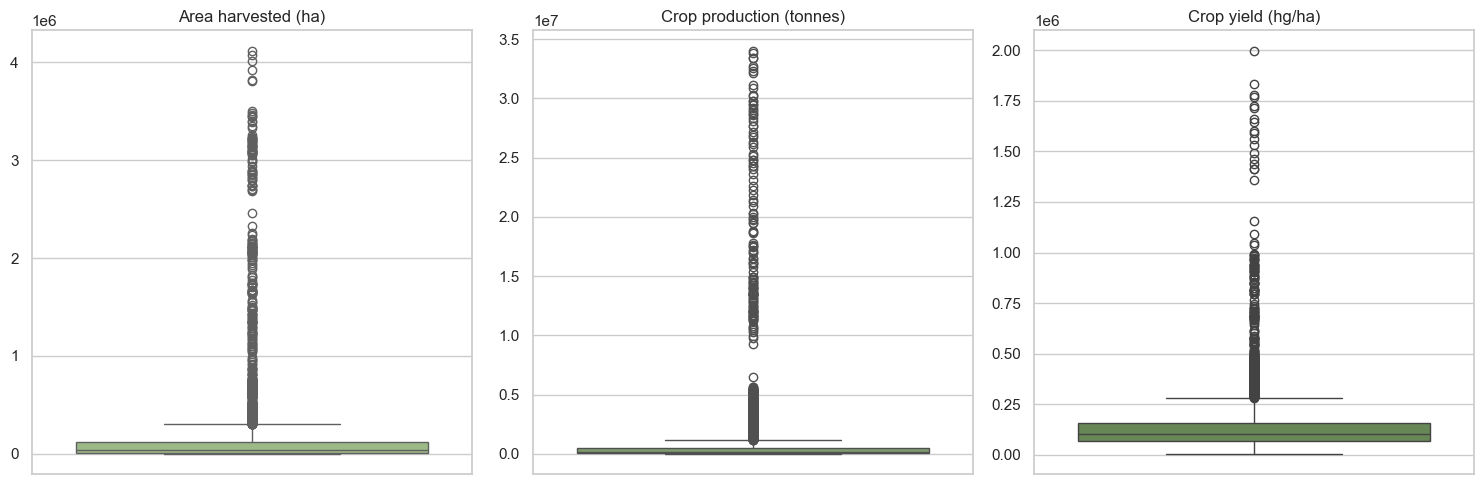

In [322]:
# Create boxplot
df_var1 = df_filtered.groupby(['Area','Year'])['area_harvested_ha'].mean().reset_index()
df_var2 = df_filtered.groupby(['Area','Year'])['production_tonnes'].mean().reset_index()
df_var3 = df_filtered.groupby(['Area','Year'])['yield_hg/ha'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

fig = sns.boxplot(y=df_var1['area_harvested_ha'], data=df_var1, ax=axes[0], color = agro[1]) 
axes[0].set_title('Area harvested (ha)')
axes[0].set_ylabel('')  

fig = sns.boxplot(y=df_var2['production_tonnes'], data=df_var2, ax=axes[1], color = agro[2]) 
axes[1].set_title('Crop production (tonnes)')
axes[1].set_ylabel('') 

fig = sns.boxplot(y=df_var3['yield_hg/ha'], data=df_var3, ax=axes[2], color = agro[3])  
axes[2].set_title('Crop yield (hg/ha)')
axes[2].set_ylabel('')  

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [323]:
# # repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
# def repair_outliers(df, col):
#     Q1 = col.quantile(0.25)
#     Q3 = col.quantile(0.75)
#     IQR = Q3 - Q1
    
#     outlier_lower = Q1 - (1.5 * IQR)
#     outlier_upper = Q3 + (1.5 * IQR)
    
#     for i in range(len(df[col.name])): 
#         if i in df.index:  
#             element = df.loc[i, col.name] 
#             if element > outlier_upper: 
#                 df.loc[i, col.name] = outlier_upper
#             elif element < outlier_lower: 
#                 df.loc[i, col.name] = outlier_lower
            
#     return df  

# repair_outliers(df_var1, df_var1['area_harvested_ha'])
# repair_outliers(df_var2, df_var2['production_tonnes'])
# repair_outliers(df_var3, df_var3['yield_hg/ha'])

In [324]:
# # Boxplot
# # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

# fig = sns.boxplot(y=df_var1['area_harvested_ha'], data=df_var1, ax=axes[0], color = agro[1]) 
# axes[0].set_title('Area harvested (ha)')
# axes[0].set_ylabel('')  

# fig = sns.boxplot(y=df_var2['production_tonnes'], data=df_var2, ax=axes[1], color = agro[2]) 
# axes[1].set_title('Crop production (tonnes)')
# axes[1].set_ylabel('') 

# fig = sns.boxplot(y=df_var3['yield_hg/ha'], data=df_var3, ax=axes[2], color = agro[3])  
# axes[2].set_title('Crop yield (hg/ha)')
# axes[2].set_ylabel('')  

# # Adjust the design
# plt.tight_layout()

# # Show
# plt.show()

In [325]:
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
area_harvested_ha,143236.00,230409.84,1642560.09,1.00,733.00,5063.00,35942.25,46400000.00
production_tonnes,143236.00,1364555.02,12971150.43,0.06,4428.00,35000.00,231800.00,768594154.00
yield_hg/ha,143236.00,140882.37,298056.73,9.00,24023.75,71794.00,163469.25,8755278.00
avg_rainfall_mm_year,143236.00,1148.16,763.87,56.00,591.00,1032.00,1668.00,3205.11
avg_temp_ºC,143236.00,19.50,7.51,-3.96,12.68,21.87,25.56,29.65


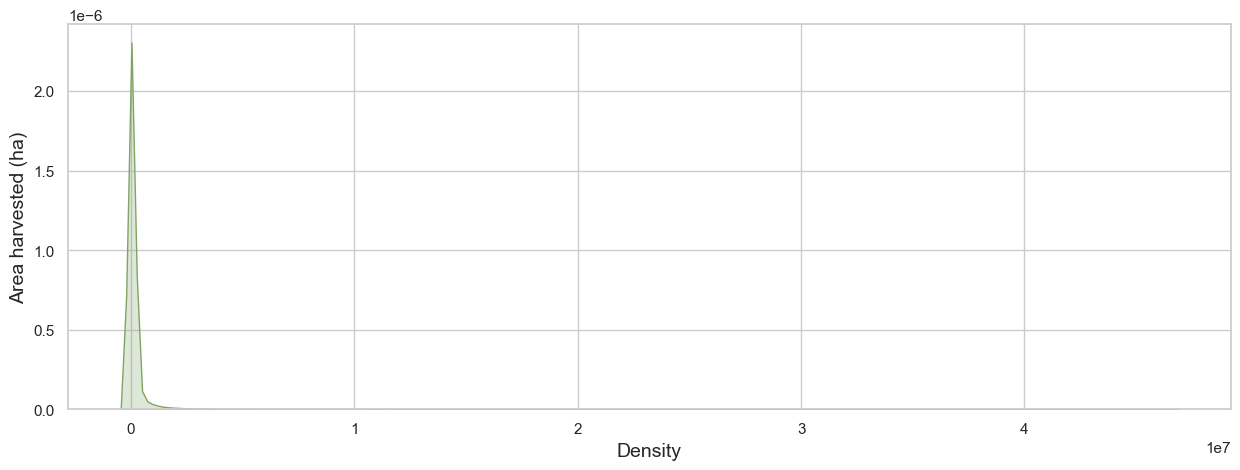

In [326]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_filtered, x='area_harvested_ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Area harvested (ha)', fontsize=14)
plt.show()

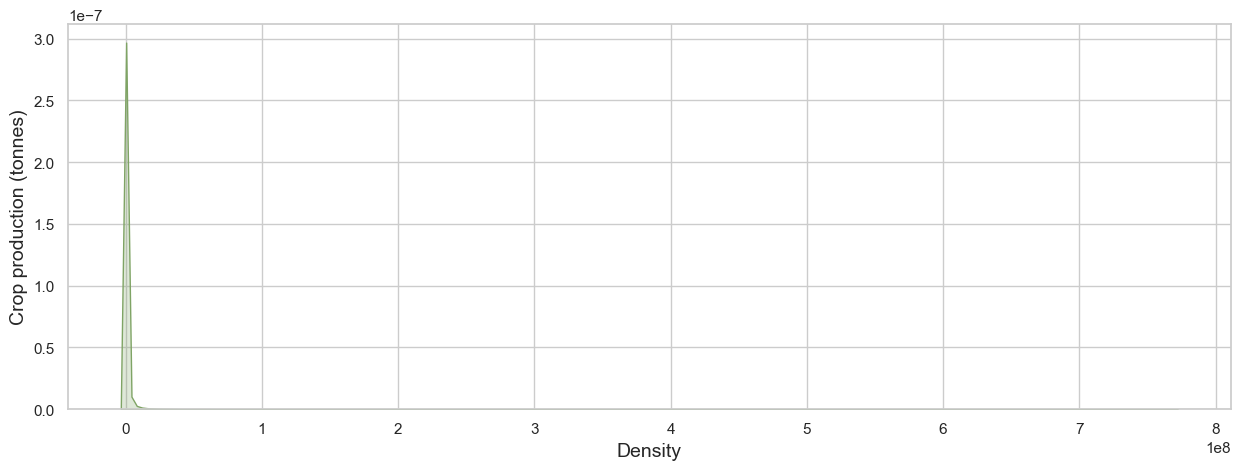

In [327]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_filtered, x='production_tonnes', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Crop production (tonnes)', fontsize=14)
plt.show()

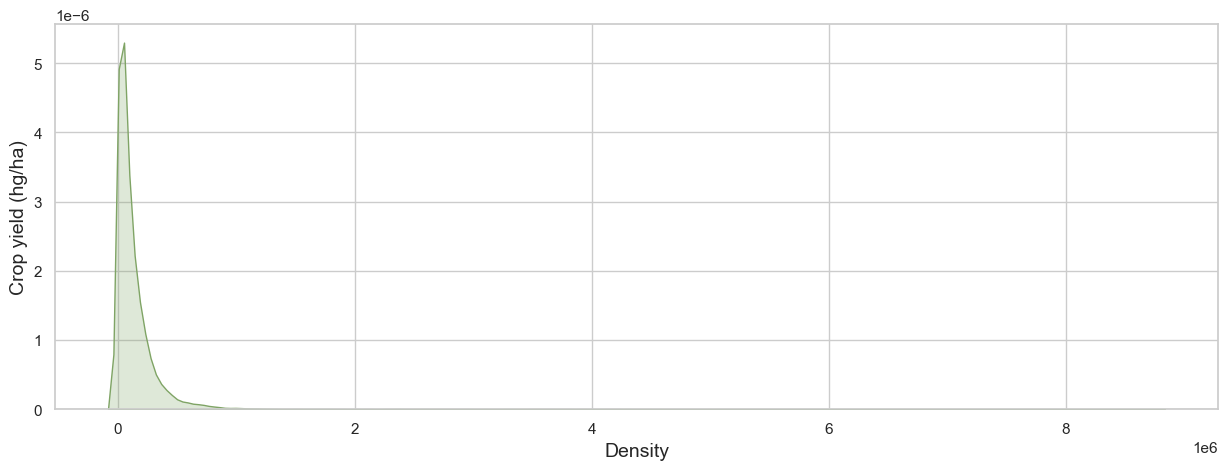

In [328]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_filtered, x='yield_hg/ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Crop yield (hg/ha)', fontsize=14)
plt.show()

In [419]:
# Save final df in csv:
df_filtered.to_csv('Data/df_preprocessed.csv', index=False)